# Exponential Integrate-and-fire model

## Model Introduction

Exponential Integrate-and-fire model(ExpIF model) is a neuron model derive from LIF model. 

## Model Implementation

explain VT

In [1]:
import numpy as np
import brainpy as bp
import matplotlib.pyplot as plt

In [2]:
## define Exponential Leaky Integrate-and-Fire model
def ExpIF_model(Vrest = -65., Vreset = -68. , Vth = -30., VT = -59.9, delta_T = 3.48, 
                  Rm = 10., Cm = 1., tau_m = 10., refTime = 1.7, noise = 0.):
    ST = bp.types.NeuState(
        {'Vm': -65., 'refState': 0, 'input': 0, 'isFire': 0, 'spikeCnt':0}
    )
    '''
    ExpIF neuron model.
    Vm: voltage of membrane.
    refState: refractory state.
    input: external input, from stimulus and other synapses.
    isFire: if neuron generates a spike at this moment, then flag isFire = 1, otherwise isFire = 0.
    spikeCnt: total spike cnt (record to compute firing rate).
    '''
    
    @bp.integrate
    def int_v(V, _t_, I_syn):  # integrate u(t)
        return (- ( V - Vrest ) + delta_T * exp((V - VT)/delta_T) + Rm * I_syn) / tau_m, 0.  #, noise / tau_m

    def update(ST, _t_):  
        # update variables
        refPeriod = refTime // dt  #refractory
        ST['isFire'] = 0
        if ST['refState'] <= 0:
            V = int_v(ST['Vm'], _t_, ST['input'])
            if V >= Vth:
                V = Vreset
                ST['refState'] = refPeriod
                ST['spikeCnt'] += 1
                ST['isFire'] = 1
            ST['Vm'] = V
        else:
            ST['refState'] -= 1
        ST['input'] = 0.  #ST['input'] is current input (only valid for current step, need reset each step)
    
    return bp.NeuType(name = 'Exp_LIF_neuron', requires = dict(ST=ST), steps = update, vector_based = False)

version： 0.2.0
Compilation used 0.7222 ms.
Start running ...
Run 10.0% used 0.001 s.
Run 20.0% used 0.002 s.
Run 30.0% used 0.002 s.
Run 40.0% used 0.003 s.
Run 50.0% used 0.003 s.
Run 60.0% used 0.004 s.
Run 70.0% used 0.005 s.
Run 80.0% used 0.005 s.
Run 90.0% used 0.006 s.
Run 100.0% used 0.006 s.
Simulation is done in 0.006 s.


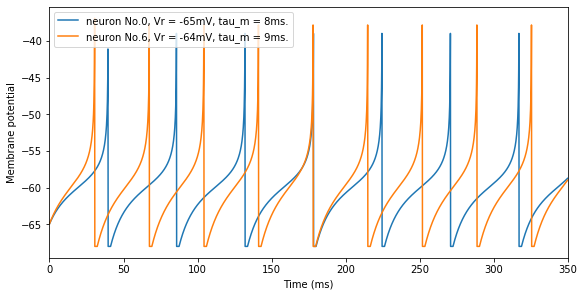

In [3]:
if __name__ == '__main__':
    print("version：", bp.__version__)
    ## set global params
    dt = 0.125        # update variables per <dt> ms
    duration = 350.  # simulate duration
    bp.profile.set(backend = "numba", dt = dt, merge_steps = True, show_code = False)
    ExpIF_neuron = ExpIF_model(noise = 0.)

    neu = bp.NeuGroup(ExpIF_neuron, geometry = (10, ), monitors = ['Vm', 'isFire'],
                      pars_update = {
                     'Vrest': np.random.randint(-65, -63, size = (10,)),
                     'tau_m': np.random.randint(5, 10, size = (10,)) # ,
                     #'noise': 1.
                     })  #create a neuron group with 10 neurons.
    net = bp.Network(neu)
    
    current, pos_dur = bp.inputs.constant_current([(0.30, duration)])
    
    net.run(duration = pos_dur, inputs = [neu, "ST.input", current], report = True)  
    #simulate for <duration> ms. Give external input = [receiver, field name, strength]

    #paint
    ts = net.ts
    fig, gs = bp.visualize.get_figure(1, 1, 4, 8)

    fig.add_subplot(gs[0, 0])
    plt.plot(ts, neu.mon.Vm[:, 0], label = f'neuron No.{0}, Vr = {neu.pars.get("Vrest")[0]}mV, tau_m = {neu.pars.get("tau_m")[0]}ms.')
    plt.plot(ts, neu.mon.Vm[:, 6], label = f'neuron No.{6}, Vr = {neu.pars.get("Vrest")[6]}mV, tau_m = {neu.pars.get("tau_m")[6]}ms.')
    #paint Vm-t plot of 1st and 2nd neuron
    plt.ylabel('Membrane potential')
    plt.xlim(-0.1, net.t_end - net.t_start + 0.1)
    plt.legend()
    plt.xlabel('Time (ms)')
    '''
    fig, gs = bp.visualize.get_figure(1, 1, 4, 8)
    fig.add_subplot(gs[0, 0])
    plt.plot(ts, neu.mon.isFire[:, 0], label = f'neuron No.{0}, Vr = -65mV, tau_m = 10ms.')
    #paint Vm-t plot of 1st and 2nd neuron
    plt.ylabel('Membrane potential')
    plt.xlim(-0.1, net.t_end - net.t_start + 0.1)
    plt.legend()
    plt.xlabel('Time (ms)')'''

    plt.show()

## Model Virsualization

## Model Analysis

1. check Threshold = 0.16
2. realize WB model fit
3. check when VT->Vth, delta_T->0

## References

[1] How spike generation mechanisms determine the neuronal response to fluctuating inputs